In [38]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [50]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 100
group_dict = OrderedDict([('1',[11,21]),('2',[12,22])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub,num_labels=2)

In [51]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)

    xdata_color, ydata_color = wrangl.select_labels(xdata,ydata,labels=[11,12])
    xdata_motion, ydata_motion = wrangl.select_labels(xdata,ydata,labels=[21,22])
    xdata_color, ydata_color = wrangl.group_labels(xdata_color, ydata_color)
    xdata_motion, ydata_motion = wrangl.group_labels(xdata_motion, ydata_motion)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_custom_split(xdata_color,xdata_motion,ydata_color,ydata_motion):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)


0
1
2
3
4
5
6
7
8


In [54]:
interp = eeg_decoder.Interpreter(clfr, subtitle='color_to_motion') 
interp.save_results()
# interp.load_results('color_to_motion')

Significant timepoints: [ 328  352  400  496  520  544  568  592  616  688  976 1024]
Mean delay accuracy: 0.5655902777777777
Mean delay S.D.: 0.023564675538953896


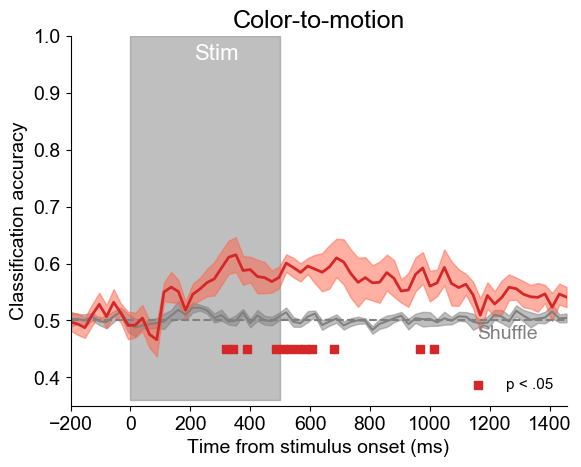

In [53]:
import matplotlib.pyplot as plt
interp.chance = .5
interp.labels = [0,1]
interp.plot_acc(significance_testing=True,savefig=False,
                ylim=[0.35,1],chance_text_y=.22,
                title='Color-to-motion',stim_time=[0,500])
plt.show()

In [61]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)

    xdata_color, ydata_color = wrangl.select_labels(xdata,ydata,labels=[11,12])
    xdata_motion, ydata_motion = wrangl.select_labels(xdata,ydata,labels=[21,22])
    xdata_color, ydata_color = wrangl.group_labels(xdata_color, ydata_color)
    xdata_motion, ydata_motion = wrangl.group_labels(xdata_motion, ydata_motion)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_custom_split(xdata_motion,xdata_color,ydata_motion,ydata_color):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)


0
1
2
3
4
5
6
7
8


In [62]:
interp = eeg_decoder.Interpreter(clfr, subtitle='motion_to_color') 
interp.save_results()

In [14]:
interp.load_results('motion_to_color')

Significant timepoints: [ 112  136  160  184  208  232  256  304  328  352  376  400  424  448
  472  496  520  544  568  592  616  640  664  688  712  736  784  808
  832  856  880  952  976 1000 1024 1048 1144 1192 1216 1240 1264 1288
 1336 1360 1384 1456]
Mean delay accuracy: 0.5556805555555556
Mean delay S.D.: 0.023836744608241263


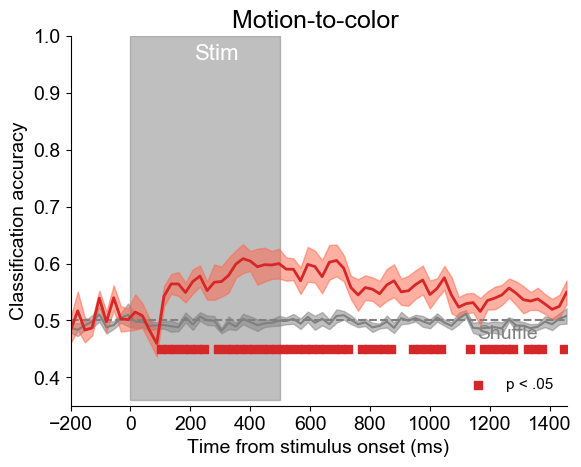

In [63]:
import matplotlib.pyplot as plt
interp.chance = .5
interp.labels = [0,1]
interp.plot_acc(significance_testing=True,savefig=False,
                ylim=[0.35,1],chance_text_y=.22,
                title='Motion-to-color ',stim_time=[0,500])
plt.show()

# Across feature

In [64]:
interp_color_to_motion = eeg_decoder.Interpreter()
interp_color_to_motion.load_results(filename = 'color_to_motion')
interp_motion_to_color = eeg_decoder.Interpreter()
interp_motion_to_color.load_results('motion_to_color')

interp_color = eeg_decoder.Interpreter()
interp_color.load_results('color')
interp_color.acc = interp_color.acc
interp_color.acc_shuff = interp_color.acc_shuff
interp_motion = eeg_decoder.Interpreter()
interp_motion.load_results('motion')

# color

In [65]:
# Combine acc matrices for plotting
interp_color.acc = np.concatenate([interp_color.acc[:,np.newaxis],interp_motion_to_color.acc[:,np.newaxis]],1)
interp_color.acc_shuff = np.concatenate([interp_color.acc_shuff[:,np.newaxis],interp_motion_to_color.acc_shuff[:,np.newaxis]],1)

Within-color mean delay accuracy: 0.6352569444444445
Within-color mean delay S.D.: 0.035131113956492654
Motion-to-color mean delay accuracy: 0.5556805555555556
Motion-to-color mean delay S.D.: 0.023836744608241263
mean delay accuracy: 0.5556805555555556
mean delay S.D.: 0.023836744608241263


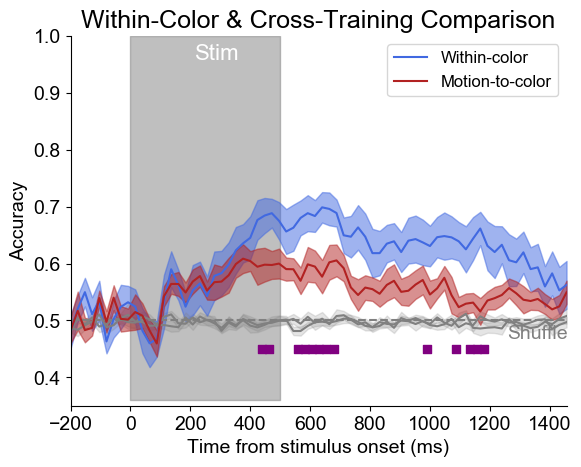

In [66]:
interp_color.plot_acc_compare_subset(
    subset_list=['Within-color','Motion-to-color'],
    ylim=[.35,1], 
    chance=.5, 
    chance_text_y=.22,
    stim_time=[0,500],
    significance_testing=True,
    subtitle='within_color_and_motion_to_color',
    title='Within-Color & Cross-Training Comparison',
    savefig=False)

# motion 

In [58]:
# Combine acc matrices for plotting
interp_motion.acc = np.concatenate([interp_motion.acc[:,np.newaxis],interp_color_to_motion.acc[:,np.newaxis]],1)
interp_motion.acc_shuff = np.concatenate([interp_motion.acc_shuff[:,np.newaxis],interp_color_to_motion.acc_shuff[:,np.newaxis]],1)

Within-motion mean delay accuracy: 0.6713819444444444
Within-motion mean delay S.D.: 0.03289187082106147
Color-to-motion mean delay accuracy: 0.5655902777777777
Color-to-motion mean delay S.D.: 0.023564675538953896
mean delay accuracy: 0.5655902777777777
mean delay S.D.: 0.023564675538953896


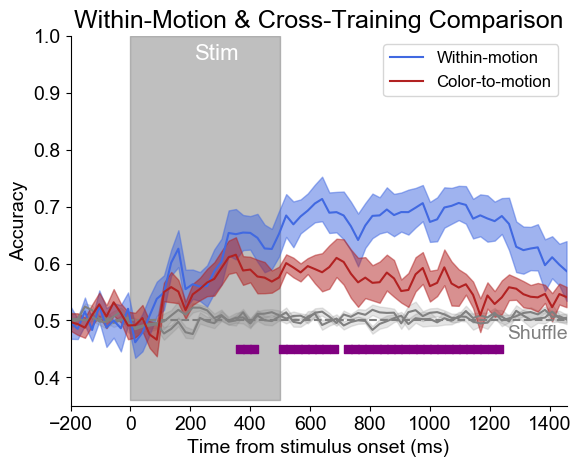

In [59]:
interp_motion.plot_acc_compare_subset(
    subset_list=['Within-motion','Color-to-motion'],
    ylim=[.35,1], 
    chance=.5, 
    chance_text_y=.22,
    stim_time=[0,500],
    significance_testing=True,
    subtitle='within_motion_and_color_to_motion',
    title='Within-Motion & Cross-Training Comparison',
    savefig=False)